# Splitting series by mjd into 3 bins

### Demonstration

In [ ]:
import pandas as pd
import numpy as np
from typing import Tuple
from functools import partial
import multiprocessing as mp
from scipy.stats import linregress
from tqdm import tqdm

In [ ]:
def polyfit_bin(bin_idx: int, bin_df: pd.DataFrame, deg: int) -> pd.Series:
    """
    Seem not to be that important, dropped to improve speed.
    Also, 'fittable' feature turned out to be ignored by model so its dropped in linear fit too.
    """
    try:
        coeffs = np.polyfit(x=bin_df['mjd'].values*1e-4, y=bin_df['flux'].values, deg=deg)
        fittable = 1
    except TypeError:  # x is too short in this bin
        coeffs = np.zeros_like(deg+1)
        fittable = 0
    bin_poly_features = pd.Series(coeffs, index = [f'bin_{bin_idx}_flux_polyfit_coeff_{i}' for i in range(deg+1)])
    bin_poly_features[f'bin_{bin_idx}_is_poly_fittable'] = fittable
    return bin_poly_features

def linreg_bin(bin_idx: int, bin_df: pd.DataFrame) -> pd.Series:
    if len(bin_df) > 1:
        slope, intercept, r_value, p_value, std_err = linregress(
            x=bin_df['mjd'].values*1e-4, 
            y=bin_df['flux'].values
        )
    else:
        slope, intercept, r_value, p_value, std_err = 0,0,0,0,0
    bin_linear = pd.Series(
        [slope, intercept, r_value, p_value, std_err], 
        index = [f'bin_{bin_idx}_{f}' for f in ['slope', 'intercept', 'r_value', 'p_value', 'std_err']]
    )
    return bin_linear


def agg_bin(bin_idx: int, bin_df: pd.DataFrame, bin_aggs: dict) -> pd.Series:
    bin_agg_df = bin_df.agg(bin_aggs)
    bin_agg_series = pd.concat([
        bin_agg_df.xs(bin_agg_df.index[i]).add_suffix(f'_{aggname}') 
        for i, aggname in enumerate(bin_agg_df.index)
    ], axis=0).add_prefix(f'bin_{bin_idx+1}_')
    return bin_agg_series

def process_bin(bin_idx: int, bin_df: pd.DataFrame, bin_aggs: dict, polyfit_deg: int) -> pd.Series:
    return pd.concat([
#         polyfit_bin(bin_idx, bin_df, polyfit_deg), 
        linreg_bin(bin_idx, bin_df),
        agg_bin(bin_idx, bin_df, bin_aggs)
    ], axis=0)

def process_group(group_data: Tuple[int, pd.DataFrame], bin_aggs: dict, polyfit_deg: int) -> pd.Series:
    group_idx, group = group_data
    min_time = group['mjd'].min()
    max_time = group['mjd'].max()
    interval = (max_time+1e-15 - min_time)/3
    bins = [group[(group['mjd'] >= min_time + i*interval) & (group['mjd'] < min_time + (i+1)*interval)] for i in range(3)]
    bins_series = [process_bin(bin_idx, bin_df, bin_aggs, polyfit_deg) for bin_idx, bin_df in enumerate(bins)]
    agg_series_all_bins = pd.concat(bins_series, axis=0).dropna().rename(group_idx)
    return agg_series_all_bins

def compute_binned_features(series_df: pd.DataFrame, bin_aggs: dict, polyfit_deg: int, n_jobs=None):
    """
    Parallel computation of series bins splitted into 
    """
    process_group_with_fixed_aggs = partial(
        process_group,
        bin_aggs=bin_aggs,
        polyfit_deg=polyfit_deg
    )
    gbo = series_df.groupby('object_id')
    if n_jobs is None:
        group_features_series = [process_group_with_fixed_aggs(g) for g in gbo]
        # not using tqdm in order to improve speed
    else:
        with mp.Pool(n_jobs) as pool:
            group_features_series = pool.map(process_group_with_fixed_aggs, gbo)
    return pd.concat(group_features_series, axis=1, sort=False).transpose()

In [ ]:
bin_aggs = {
    'flux': ['mean', 'skew', 'kurtosis'],
    'flux_err': ['mean', 'std'],
#     'detected': ['mean']
}
polyfit_deg = 3

In [ ]:
df = pd.read_csv('../data/raw/training_set.csv')

We will generate some basic features + measure time of execution and profile process_bin:

In [ ]:
%load_ext line_profiler

In [286]:
%%time 
%lprun -f process_bin df_feat = compute_binned_features(df, bin_aggs, polyfit_deg, n_jobs=None)

TypeError: compute_binned_features() got multiple values for argument 'n_jobs'

In [ ]:
df_feat.head()

In [ ]:
df_feat.shape

In [ ]:
assert(df_feat.isna().any().sum()==0)

Inspect how many curves were fitted successfully:

In [ ]:
df_feat[[col for col in df_feat.columns if col.endswith('fittable')]].sum()

### Testing importance versus standard features

At the time of writing this, binned features were not generated as a part of featurize yet.

In [ ]:
from plasticc.featurize import compute_binned_features

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Set
from datetime import datetime as dt

from plasticc.featurize import process_meta, featurize
from plasticc.training import path_from_cv_score, train_and_validate
from plasticc.final import featurize_test, predict_test

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
fcp = {
    'flux': {
        'longest_strike_above_mean': None,
        'longest_strike_below_mean': None,
        'mean_change': None,
        'mean_abs_change': None,
        'length': None,
    },

    'flux_by_flux_ratio_sq': {
        'longest_strike_above_mean': None,
        'longest_strike_below_mean': None,       
    },

    'flux_passband': {
        'fft_coefficient': [
                {'coeff': 0, 'attr': 'abs'}, 
                {'coeff': 1, 'attr': 'abs'}
            ],
        'kurtosis' : None, 
        'skewness' : None,
    },

    'mjd': {
        'maximum': None, 
        'minimum': None,
        'mean_change': None,
        'mean_abs_change': None,
    },
}

In [ ]:
aggs = {
    'flux': ['min', 'max', 'mean', 'median', 'std', 'skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std', 'skew'],
    'detected': ['mean'],
    'flux_ratio_sq':['sum', 'skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
}

### Generate features for model training

In [271]:
%%time
meta_train = process_meta('../data/raw/training_set_metadata.csv')
train = pd.read_csv('../data/raw/training_set.csv')

CPU times: user 1.31 s, sys: 288 ms, total: 1.6 s
Wall time: 1.07 s


In [272]:
%%time
X = featurize(train, meta_train, aggs, fcp, n_jobs=16)



Feature Extraction:   0%|          | 0/80 [00:00<?, ?it/s]

Feature Extraction:   1%|▏         | 1/80 [00:00<00:34,  2.27it/s]

Feature Extraction:   4%|▍         | 3/80 [00:00<00:25,  3.05it/s]

Feature Extraction:   6%|▋         | 5/80 [00:00<00:18,  3.98it/s]

Feature Extraction:   8%|▊         | 6/80 [00:00<00:15,  4.81it/s]

Feature Extraction:   9%|▉         | 7/80 [00:01<00:13,  5.58it/s]

Feature Extraction:  10%|█         | 8/80 [00:01<00:22,  3.20it/s]

Feature Extraction:  20%|██        | 16/80 [00:01<00:14,  4.29it/s]

Feature Extraction:  22%|██▎       | 18/80 [00:02<00:11,  5.37it/s]

Feature Extraction:  25%|██▌       | 20/80 [00:02<00:09,  6.66it/s]

Feature Extraction:  28%|██▊       | 22/80 [00:02<00:07,  7.43it/s]

Feature Extraction:  30%|███       | 24/80 [00:02<00:06,  8.03it/s]

Feature Extraction:  32%|███▎      | 26/80 [00:02<00:06,  8.44it/s]

Feature Extraction:  35%|███▌      | 28/80 [00:03<00:05,  9.43it/s]

Feature Extraction:  38%|███▊      | 30/80 [00:

CPU times: user 58.5 s, sys: 3.61 s, total: 1min 2s
Wall time: 30.3 s


In [273]:
X_basic = X.copy()
X = X.join(df_feat, on='object_id')
X.head()

,object_id,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,...,bin_2_slope,bin_2_intercept,bin_2_r_value,bin_2_p_value,bin_2_std_err,bin_3_flux_kurtosis,bin_3_flux_mean,bin_3_flux_err_mean,bin_3_flux_skew,bin_3_flux_err_std
0,615,-1100.440063,660.626343,-123.096998,-89.477524,394.109851,-0.349540,2.130510,12.845472,4.482743,...,24030.379155,-145587.356799,0.258553,4.353893e-03,8265.047516,0.430326,-46.744086,4.365833,-0.703042,1.646093
1,713,-14.735178,14.770886,-1.423351,-0.873033,6.471144,0.014989,0.639458,9.115748,2.359620,...,101.944267,-626.112393,0.120409,1.792697e-01,75.478353,0.088545,-8.140190,2.327743,0.227280,1.455394
2,730,-19.159811,47.310059,2.267434,0.409172,8.022239,3.177854,0.695106,11.281384,2.471061,...,-2064.888302,12520.073419,-0.627233,4.880146e-13,250.217209,2.916757,7.164814,2.302723,1.912551,1.555040
3,745,-15.494463,220.795212,8.909206,1.035895,27.558208,4.979826,0.567170,55.892746,2.555576,...,-41.376100,250.654304,-0.050705,5.823329e-01,75.024479,6.088809,0.050553,2.914420,-0.605998,5.521127
4,1124,-16.543753,143.600189,7.145702,1.141288,20.051722,4.406298,0.695277,11.383690,2.753004,...,-4918.341011,29808.648947,-0.658344,3.051860e-16,517.674111,6.436583,20.589439,2.725916,2.553437,1.813782


In [274]:
if 'target' in X:
    y = X['target']
    del X['target']
else:
    print("What the duck")
    3//0

In [275]:
%%time
train_mean = X.mean(axis=0)
#train_mean.to_hdf('train_data.hdf5', 'data')
# pd.set_option('display.max_rows', 500)
#import pdb; pdb.set_trace()
X.fillna(0, inplace=True)

CPU times: user 380 ms, sys: 4 ms, total: 384 ms
Wall time: 26 ms


In [276]:
X.shape

(7848, 99)

In [277]:
y.shape

(7848,)

### Train model with CV

In [278]:
lgbm_params = {
    'device': 'cpu',
    'objective': 'multiclass',
    'num_class': 14,
    'boosting_type': 'gbdt',
    'n_jobs': 16,
    'max_depth': 5,
    'n_estimators': 1024,
    'subsample_freq': 2,
    'subsample_for_bin': 5000,
    'min_data_per_group': 100,
    'max_cat_to_onehot': 4,
    'cat_l2': 1.0,
    'cat_smooth': 59.5,
    'max_cat_threshold': 32,
    'metric_freq': 10,
    'verbosity': -1,
    'metric': 'multi_logloss',
    'xgboost_dart_mode': False,
    'uniform_drop': False,
    'colsample_bytree': 0.5,
    'drop_rate': 0.173,
    'learning_rate': 0.03,
    'max_drop': 5,
    'min_child_samples': 10,
    'min_child_weight': 100.0,
    'min_split_gain': 0.126,
    'num_leaves': 9,
    'reg_alpha': 0.1,
    'reg_lambda': 0.00023,
    'skip_drop': 0.44,
    'subsample': 0.75,
    'max_bin': 32,
    'min_data_in_leaf': 13,
    'lambda_l1': 2,
}

In [279]:
colnames_to_ignore = set([
    'object_id',
    'hostgal_specz',
    'ra',
    'decl',
    'gal_l',
    'gal_b',
    'ddf',
])
colnames_to_ignore_restrictive = colnames_to_ignore | set([
    'latlon1',
    'haversine',
])
colnames_to_ignore_very_restrictive = colnames_to_ignore_restrictive | set([
    'flux_err_skew',
    'flux_by_flux_ratio_sq_sum'
])
feature_colnames = [col for col in X.columns if col not in colnames_to_ignore]
id_colname = 'object_id'

In [280]:
new_colnames_to_ignore = []

In [281]:
feature_colnames = [col for col in X.columns if col not in colnames_to_ignore_very_restrictive]

In [282]:
clfs, score, importances = train_and_validate(
    X=X, 
    y=y,
    feature_colnames=feature_colnames, 
    id_colname=id_colname, 
    model='lgbm', 
    model_params=lgbm_params, 
    nr_fold=8, 
    random_state=1
)
submission_file_path = path_from_cv_score(score, suffix='')

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.283463	training's wloss: 0.730706	valid_1's multi_logloss: 1.60783	valid_1's wloss: 0.948083
[200]	training's multi_logloss: 0.146946	training's wloss: 0.469449	valid_1's multi_logloss: 1.25604	valid_1's wloss: 0.74816
[300]	training's multi_logloss: 0.105381	training's wloss: 0.363484	valid_1's multi_logloss: 1.09445	valid_1's wloss: 0.695373
[400]	training's multi_logloss: 0.0836781	training's wloss: 0.301492	valid_1's multi_logloss: 0.998747	valid_1's wloss: 0.669751
[500]	training's multi_logloss: 0.0694431	training's wloss: 0.258794	valid_1's multi_logloss: 0.934852	valid_1's wloss: 0.660812
[600]	training's multi_logloss: 0.0588312	training's wloss: 0.225483	valid_1's multi_logloss: 0.885632	valid_1's wloss: 0.659673
Early stopping, best iteration is:
[584]	training's multi_logloss: 0.0603613	training's wloss: 0.230214	valid_1's multi_logloss: 0.891772	valid_1's wloss: 0.658318
no 1-fo

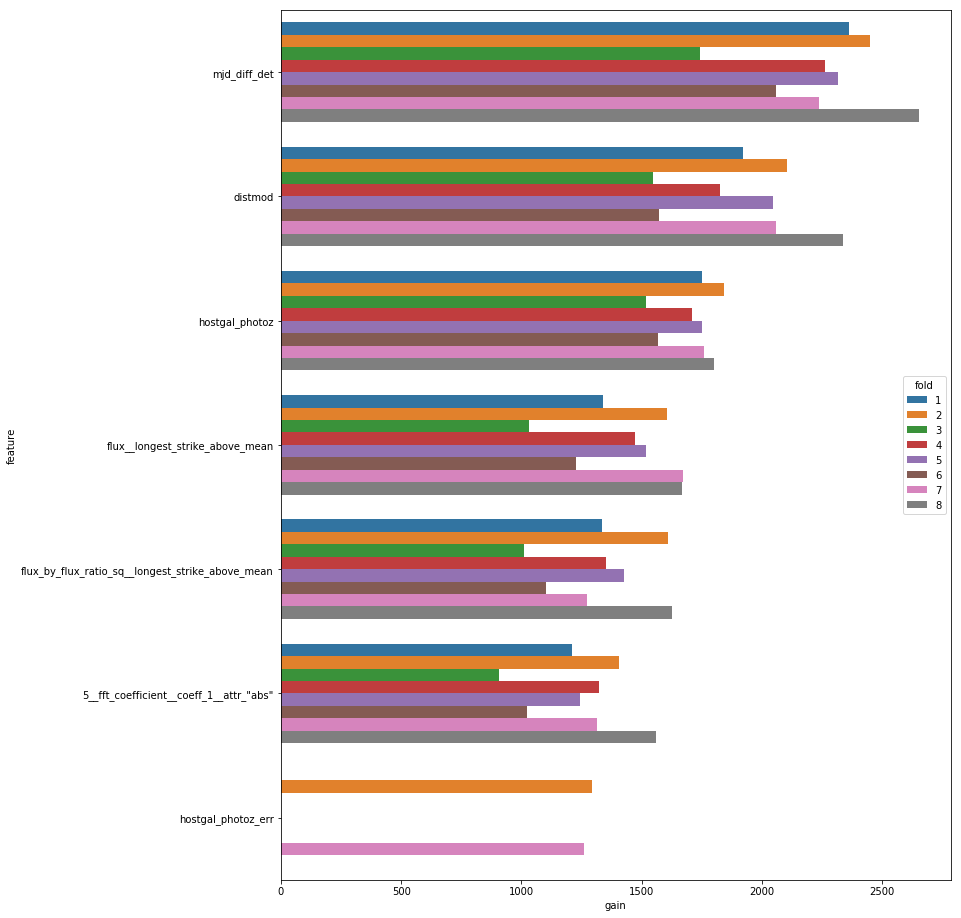

In [283]:
fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax=ax, data=importances.sort_values(by='mean_gain', ascending=False).head(50), x='gain', y='feature', hue='fold', )
plt.show()

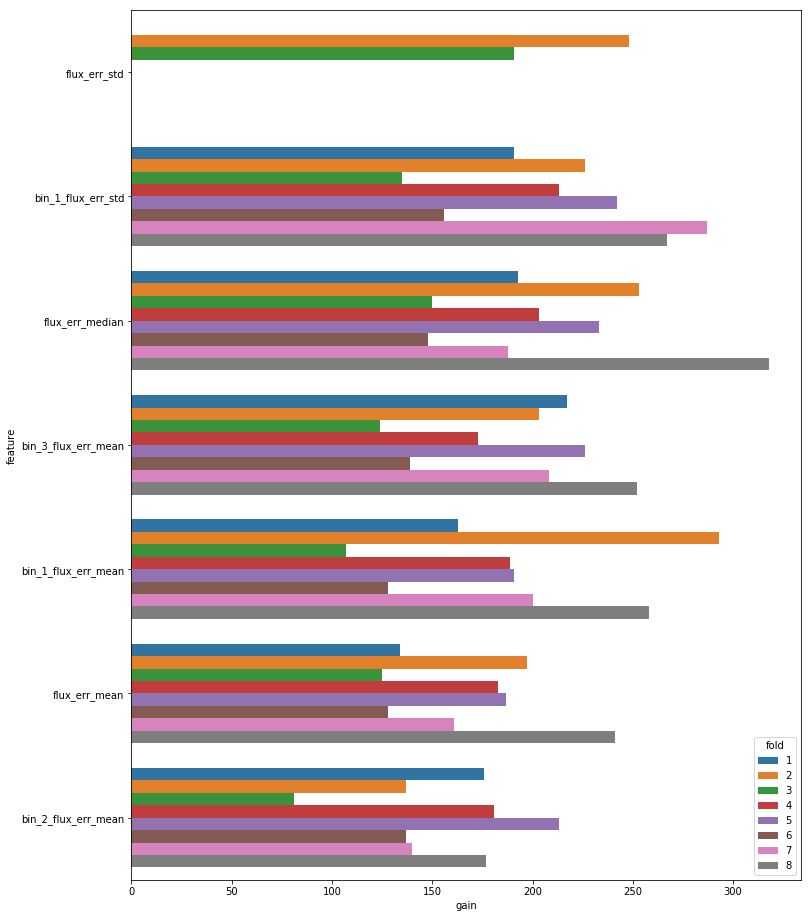

In [284]:
fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax=ax, data=importances.sort_values(by='mean_gain', ascending=False).tail(50), x='gain', y='feature', hue='fold', )
plt.show()

### Generate features for the test set

In [ ]:
sorted_importances = importances.groupby('feature').mean().sort_values(by='mean_gain', ascending=False)

In [ ]:
sns.distplot(sorted_importances['mean_gain'])

In [ ]:
sns.distplot(sorted_importances[sorted_importances['mean_gain'] < 200.]['mean_gain'], bins=20)

In [ ]:
new_features_to_drop = sorted_importances[sorted_importances['mean_gain'] < 100.].index.unique()

In [ ]:
new_features_to_drop

### Generate predictions

In [ ]:
def train_validate_predict(ignore_colnames: Set[str], name_suffix: str):
    feature_colnames = [col for col in X.columns if col not in ignore_colnames]
    clfs, score, importances = train_and_validate(
        X=X, 
        y=y,
        feature_colnames=feature_colnames, 
        id_colname=id_colname, 
        model='lgbm', 
        model_params=lgbm_params, 
        nr_fold=5, 
        random_state=1
    )
    submission_file_path = path_from_cv_score(score, suffix=name_suffix)
    print(submission_file_path)
    print(importances.sort_values(by='mean_gain', ascending=False).head(15))
    submission = predict_test(
        clfs=clfs, 
        feature_colnames=feature_colnames, 
        id_colname=id_colname, 
        input_path='../data/features/test-all-feat-from-kernel-repro.csv', 
        output_path=submission_file_path, 
        verbose=True
    )

In [ ]:
for i, ign_cols in enumerate([colnames_to_ignore, colnames_to_ignore_restrictive, colnames_to_ignore_very_restrictive]):
    print(f"Iteration {i}, ignoring columnsL ", ign_cols)
    train_validate_predict(ign_cols)

In [ ]:
print("Done")